# Bad Channel Lists

This notebook is a reference how the list of bad channels was generated in June 2023.
The general workflow follows these steps:

- Get a list of "noisy" MCMs, i.e. MCMs that have seen siginificantly more tracklets. This information has been taken from QCDB monitoring objects and from a CTF files.   

- Compare the list of noisy channels with informationa about baseline (mean) and noise (rms) from the CCDB object for noise run 534642 from 17 April 2023: Try to identifiy channels that cause the MCM to be noisy.

- Finally, this list is compared to a list of bad channels prepared by Ole.

After these steps, a yaml file is generated that can be used in the [TRD ansible repository] to mask channels at P2.

[TRD ansible repository]: https://gitlab.cern.ch/alitrd/alitrd-ansible

In [1]:
import ROOT
from IPython.display import display_html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

import re

%jsroot on

Welcome to JupyROOT 6.28/02


In [2]:
import ctypes

def get_position_from_global_mcm_index(idx):
    """Calculate Detector/ROB/MCM for MCM index
    
    Converts a unique integer MCM index into a human-readable position,
    given by detector number (0..539), ROB (0..7) and MCM (0..15).
    The function is mainly a wrapper for the C++ function 
    o2::trd::HelperMethods::GetPositionFromGlobalChannelIndex."""

    d = ctypes.c_int()
    r = ctypes.c_int()
    m = ctypes.c_int()
    c = ctypes.c_int()

    ROOT.o2.trd.HelperMethods.getPositionFromGlobalChannelIndex(idx*21, d, r, m, c)
    return tuple((d.value,r.value,m.value))

def get_global_channel_index(x):
    """Calculate the global channel index
    
    Given the position of a channel as detector/ROB/MCM and channel number in the MCM,
    the globabl channel index, a single integer between 0 and 65663 is calculated.
    This function is a wrapper around a O2 C++ function."""
    det,rob,mcm,channel = x
    return ROOT.o2.trd.HelperMethods.getGlobalChannelIndex(det, rob, mcm, channel)


# Number of tracklets per MCM

The main issue with noisy channels is that they increase the data volume, and might impact the stability of the readout tree. We can focus on channels where this is a problem by looking at normal physics runs, and try to identify which MCMs send a larger number of tracklets.

The TRD QC already contains monitoring objects (MO) for the number of tracklets per MCM that we can use to find noisy MCMs.

We load a macro that helps us to access these histograms and analyse them.

In [3]:
ROOT.gROOT.LoadMacro("TrackletNoise.C");

We now query the test CCDB, where we can find some QC monitoring objects (MOs). I am using MOs from the test QCDB, which I assume are from a test of the QC TrackletsTask. It would be better to use a recent physics run with sufficient statistics, but I do not know how to directly access MOs from the production QCDB.

In [4]:
mcmstats = ROOT.TrackletMCMStats(1684761589464, "http://ccdb-test.cern.ch:8080");

maxtracklets = mcmstats.GetMaxNTracklets()
maxtracklets

823835

[INFO] Init CcdApi with UserAgentID: 148019c2ad18-1686645003-gPwCI7, Host: http://alice-ccdb.cern.ch/
[INFO] Init CcdApi with UserAgentID: 148019c2ad18-1686645003-gPwCI7, Host: http://ccdb-test.cern.ch:8080
[INFO] ccdb reads http://ccdb-test.cern.ch:8080/qc/TRD/MO/TrackletsTask/TrackletsPerLayer/layer0/1684761589464/6d236cd2-f8a3-11ed-9996-c0a80209250c for 1684761589464 (retrieve, agent_id: 148019c2ad18-1686645003-gPwCI7), 
[INFO] ccdb reads http://ccdb-test.cern.ch:8080/qc/TRD/MO/TrackletsTask/TrackletsPerLayer/layer1/1684761589464/6d7952e4-f8a3-11ed-9996-c0a80209250c for 1684761589464 (retrieve, agent_id: 148019c2ad18-1686645003-gPwCI7), 
[INFO] ccdb reads http://ccdb-test.cern.ch:8080/qc/TRD/MO/TrackletsTask/TrackletsPerLayer/layer2/1684761589464/6dd08b8c-f8a3-11ed-9996-c0a80209250c for 1684761589464 (retrieve, agent_id: 148019c2ad18-1686645003-gPwCI7), 
[INFO] ccdb reads http://ccdb-test.cern.ch:8080/qc/TRD/MO/TrackletsTask/TrackletsPerLayer/layer3/1684761589464/6e28aa7d-f8a3-11ed-

We can check the histogram for the number of tracklets per MCM. We see that most MCMs find very few tracklets. Furthermore, there is a peak from MCMs with a bad channel that causes a tracklet to be found in almost every event. There are very few MCMs that find about two tracklets per event, hinting at two noisy channels. And finally, we see a few MCMs with a moderate number of tracklets, indicating noisy, but potentially usable channels.

In [5]:
%jsroot on
cnv = ROOT.TCanvas()
cnv.SetLogy()
mcmdf = mcmstats.AddToDF(ROOT.BuildMcmDF());
h = mcmdf.Histo1D(("hNTracklletsZoom", "hNTracklletsZoom", 1000, 0, 1.05*maxtracklets), "ntracklets")
h.Draw()
cnv.Draw()

We start our search for noisy channels by considering all MCMs that have seen at least 10% of the maximum number of tracklets. We load these MCMs into a pandas dataframe for further analysis.

The MCM index `mcmidx` is an integer number between 0 and 65663 that uniquely identifies the MCM, numbering the MCMs by sector-layer-padrow-column. This is closely related to the channel numbering in `o2::trd::HelperMethods::getGlobalChannelIndex` and `o2::trd::HelperMethods::getPositionFromGlobalChannelIndex` that is used e.g. by `o2::trd::CalibratorNoise`: channel and MCM index can be translated by multiplying or dividing by the number of channels per MCMs (21).

In [6]:
qcdb_noisy_mcms = pd.DataFrame(np.asarray(mcmstats.FindNoisyMCMs(int(0.1*maxtracklets))), columns=("mcmidx", "qcdb"))
qcdb_noisy_mcms.set_index("mcmidx", inplace=True)
qcdb_noisy_mcms

,qcdb
mcmidx,
15,413948
867,279060
875,412076
883,196309
891,414273
...,...
63967,395404
64351,413143
64359,413001


# Tom's list of noisy MCMs

I took a closer look at a four files from physics run 536416 (the same run that Ole used), to get the number of tracklets produced by each MCM. I downloaded 4 CTF files and determined the number of tracklets seen by each MCM. The results were saved to a CSV file that is loaded here.

The funny suffixes `/I` and `/F` of the column names are used by ROOT's `TTree::ReadFile` and can be removed.

In [7]:
tom_mcms = pd.read_csv('tom_noisy_mcms.csv').rename(columns=lambda x: re.sub("/[FI]$","", x))
tom_mcms = tom_mcms.set_index("mcmidx").rename(columns={"ntracklets": "tom_ntracklets"})
display(tom_mcms)
print(f"Tom found {len(tom_mcms)} noisy MCMs")

,tom_ntracklets
mcmidx,
15,50949
867,11157
875,47027
883,22506
891,50955
...,...
63967,50904
64351,50848
64359,50835


Tom found 108 noisy MCMs


So we found 102 noisy MCMs in the QCDB object versus 108 in the CTF files analysed by Tom.

In [8]:
all_mcms_index = qcdb_noisy_mcms.index.union(tom_mcms.index)

allmcms = qcdb_noisy_mcms.reindex(all_mcms_index, fill_value=-1)
allmcms = allmcms.merge(tom_mcms.reindex(all_mcms_index, fill_value=-1), on="mcmidx", how="outer")

display(allmcms)

,qcdb,tom_ntracklets
mcmidx,,
15,413948,50949
867,279060,11157
875,412076,47027
883,196309,22506
891,414273,50955
...,...,...
63967,395404,50904
64351,413143,50848
64359,413001,50835


We can now compare where the two methods did not agree on flagging the MCMs.

In [9]:
display(allmcms[allmcms['qcdb']<0])
display(allmcms[allmcms['tom_ntracklets']<0])

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

,qcdb,tom_ntracklets
mcmidx,,
4879,-1,14801
5895,-1,31212
8542,-1,10204
9046,-1,13089
9507,-1,36341
27111,-1,17713


,qcdb,tom_ntracklets
mcmidx,,


We see that noisy MCMs seen by QC are a subset of the noisy MCMs from Tom's CTF analysis.
6 additional MCMs were noisy in the CTFs.

# Ole's list of bad channels

On 16 May 2023, Ole suggested in an email to Tom and Benjamin a list of bad channels. The list is conservative, marking only MCMs as bad if a corresponding channel with high noise is found.

We also calculate the channel and MCM indices that were already mentioned above.

The list has been converted to a CSV file and contains 60 channels in 43 MCMs.

In [10]:
# Read Ole's list of bad channels into a pandas dataframe

ole_channels = pd.read_csv('listChannelsToBeMasked-Ole-20230516.csv').rename(columns=lambda x: re.sub("/[FI]$","", x))
ole_channels["detector"] = ole_channels['sector']*30 + ole_channels['stack']*6 + ole_channels['layer']
ole_channels["chidx"] = ole_channels[["detector","rob","mcm","channel"]].apply(get_global_channel_index, axis=1)
ole_channels["mcmidx"] = ole_channels["chidx"] // 21
ole_channels.set_index("chidx", inplace=True)
display(ole_channels.head(10))
print(f"Ole marked {len(ole_channels)} channels as bad")

,sector,stack,layer,rob,mcm,channel,mean,rms,nentries,detector,mcmidx
chidx,,,,,,,,,,,
18226,0,2,1,0,3,1,469.191200,19.727690,28350,13,867
18227,0,2,1,0,3,0,480.677000,17.689700,28350,13,867
18394,0,2,1,0,7,1,485.934450,18.053848,28350,13,875
18395,0,2,1,0,7,0,424.611850,18.296122,28350,13,875
18562,0,2,1,0,11,1,461.372700,15.769705,28350,13,883
18563,0,2,1,0,11,0,474.710450,15.397505,28350,13,883
18730,0,2,1,0,15,1,432.060120,15.520162,28350,13,891
18731,0,2,1,0,15,0,399.750150,16.514112,28350,13,891
46904,0,3,3,2,13,9,18.397722,18.413471,28350,21,2233


Ole marked 60 channels as bad


Next, we group these channels by MCM and determine an ADC mask for each of the MCMs that can be used for the wingDB entries.

In [11]:
ole_data = ole_channels.groupby("mcmidx")["channel"]
ole_mcms = pd.DataFrame(ole_data.agg(lambda x: sum(1<<i for i in x)).rename("ole_mask"))
print(f"Ole marked {len(ole_channels)} channels in {len(ole_mcms)} MCMs as noisy.")

Ole marked 60 channels in 43 MCMs as noisy.


So far, we have seen 102 noisy MCMs in plots from the (test) QCDB, 108 from my analysis, and 43 that were suggested by Ole. We can merge everything into one data frame to compare these lists.

In [12]:
all_mcms_index = ole_mcms.index.union(qcdb_noisy_mcms.index).union(tom_mcms.index)

alldata = qcdb_noisy_mcms.reindex(all_mcms_index, fill_value=-1)
alldata = alldata.merge(ole_mcms.reindex(all_mcms_index, fill_value=0x0), on="mcmidx", how="outer") 
alldata = alldata.merge(tom_mcms.reindex(all_mcms_index, fill_value=-1), on="mcmidx", how="outer")

display(alldata)
print(f"Found {len(alldata)} MCMs for further investigation")

,qcdb,ole_mask,tom_ntracklets
mcmidx,,,
15,413948,0,50949
867,279060,3,11157
875,412076,3,47027
883,196309,3,22506
891,414273,3,50955
...,...,...,...
63967,395404,0,50904
64351,413143,0,50848
64359,413001,0,50835


Found 108 MCMs for further investigation


We see that my list is the most inclusive, with slightly more flagged MCMs than the QCDB would suggest. Ole's list is more restricted, as he looked compared it with noise data.

We can visualize this relation with a Venn diagram.

/eos/user/t/tdietel/.local/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


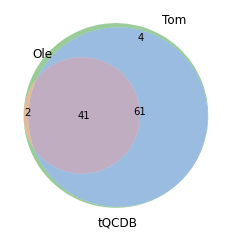

In [13]:
subset = {
    "Ole": set(alldata[alldata['ole_mask']>0].index),
    "Tom": set(alldata[alldata['tom_ntracklets']>0].index),
    "tQCDB": set(alldata[alldata['qcdb']>0].index)
}

venn3(subset.values(), subset.keys())


# Noise Run 534642

This noise run was taken on 17 April 2023. It serves as a first reference for noisy channels, but it would be usefule to have another run for comparision. We can access the CCDB objects for this run with this time stamp: 

In [14]:
timestamp = 1681740512656 # for run 534642, taken on Mon Apr 17 16:08:32

We will use the macro `Detectors/TRD/macros/CheckNoiseRun.C` from the O2 Git repository to look at a summary of this run.

In [15]:
ROOT.gROOT.LoadMacro("CheckNoiseRun.C");

We define a channel status classifier, which is used to classify and count problematic channels with the macro `CheckNoiseRun.C`. This classifation was not tuned to produce a stable list of bad channels, but it nevertheless gives a first indication of how many channels should be masked.

In [16]:
%%cpp

// Set up default classifier - easier in ROOT syntax

classifier = ChannelStatusClassifier({
    {"Good", kGreen + 1, 9.0, 10.2, 0.7, 1.8},
    {"LowNoise", kRed, 9.0, 10.2, 0.0, 0.7},
    {"Noisy", kRed, 9.0, 10.2, 1.8, 6.0},
    {"HighMeanRMS", kRed, 8.0, 25.0, 6.0, 30.0},
    {"HighMean", kRed, 10.5, 25.0, 2.0, 6.0},
    {"HighBaseline", kRed, 10.5, 520.0, 0.0, 10.0},
    {"VeryHighNoise", kRed, 0.0, 200.0, 30.0, 180.0},
    {"Ugly1", kRed, 200., 350., 15.0, 45.0},
    {"Ugly2", kRed, 200., 350., 45.0, 70.0},
    {"Ugly3", kRed, 350., 550., 10.0, 25.0},
    {"Ugly4", kRed, 350., 550., 25.0, 60.0}
});

In [17]:
df1 = ROOT.BuildNoiseDF(timestamp)
classifier = ROOT.classifier
df = classifier.AddToRDF(df1)

[INFO] ccdb reads http://ccdb-test.cern.ch:8080/TRD/Calib/ChannelStatus/1679064254530/28e85272-d858-11ed-9a2f-c0a80209250c for 1681740512656 (retrieve, agent_id: 148019c2ad18-1686645003-gPwCI7), 


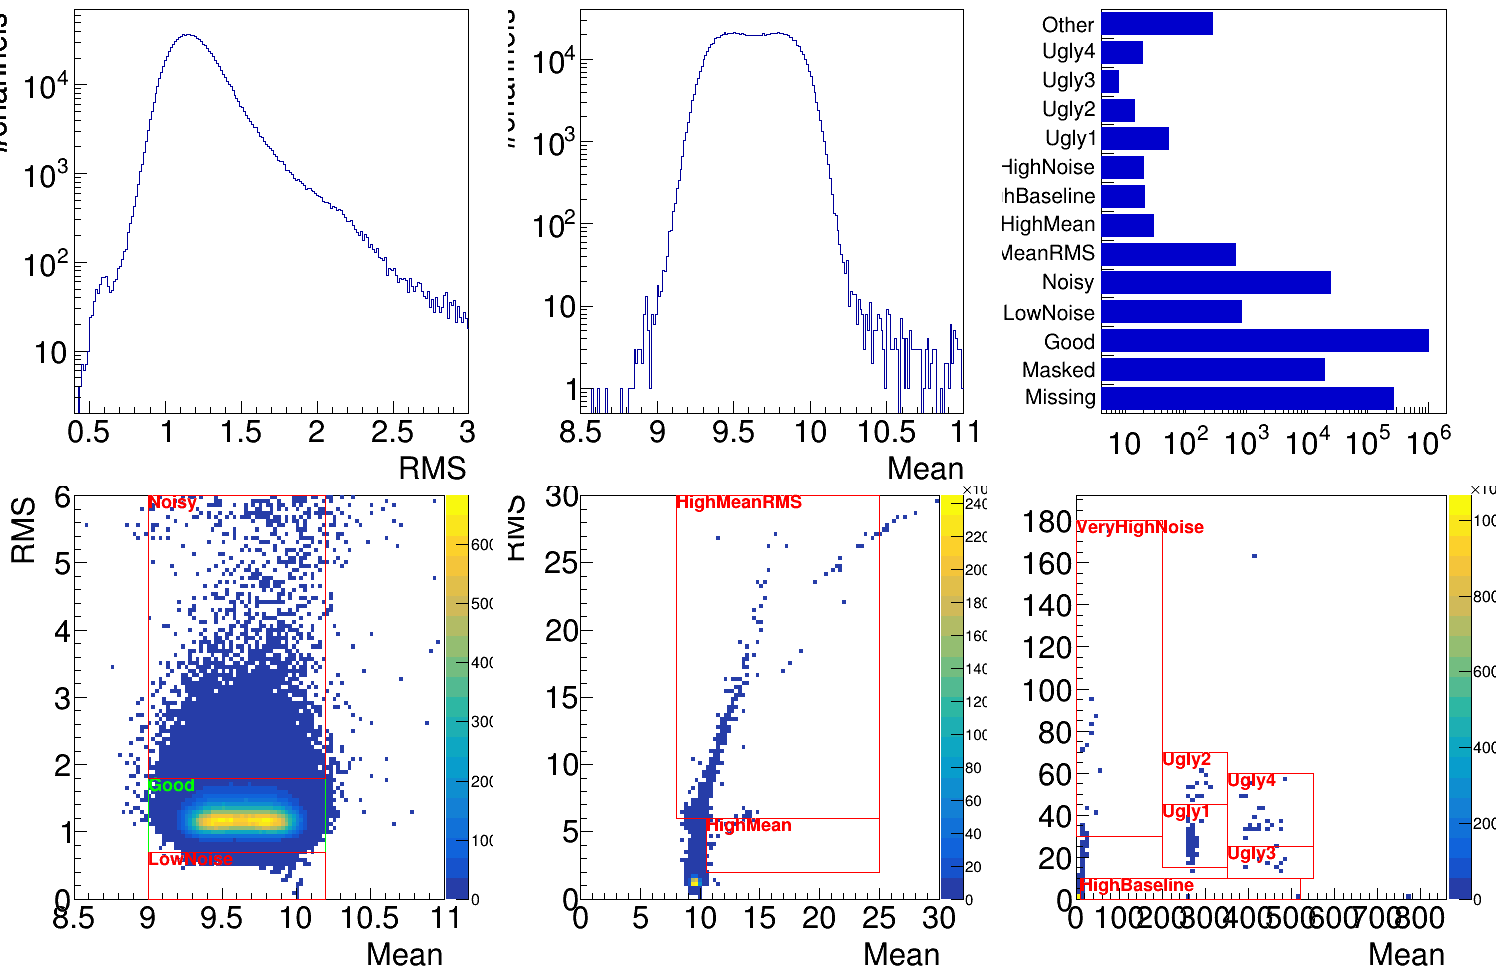

In [18]:
%jsroot off
ROOT.MakeRunSummary(df, classifier).Draw()

We could now use this data frame to generate a list of all channels in classes HighBaseline (stored as class=5), VeryHighNoise (class=6) and Ugly1-4 (classes 7-10). 
However, we will just retrieve the channels that have a slightly higher than usual noise or baseline, to see if we see any anomalies for the MCMs that we already flagged as noisy.

In [19]:
## We will use pandas dataframes rather than the clumsier ROOT ones.
# noisy_channel_df = df.Filter("class>=5")
# noisy_channel_list = noisy_channel_df.Display("", 10)

# print("Number of bad channels from noise run:", noisy_channel_df.Count().GetValue())
# noisy_channel_list.Print()


In [20]:
noisy_channels_rdf = df.Filter("mean>11.0 || rms>3.0")

noisy_channels = pd.DataFrame(noisy_channels_rdf.Alias("chidx", "rdfentry_").AsNumpy())
noisy_channels['mcmidx'] = noisy_channels['chidx'] // 21
noisy_channels['channel'] = noisy_channels['chidx'] % 21
noisy_channels

,chidx,class,col,layer,mean,nentries,rms,row,sector,mcmidx,channel
0,1974,2,126,0,9.619450,360,3.103253,11,0,94,0
1,2054,2,38,0,10.105560,360,3.211090,12,0,97,17
2,16253,11,125,1,266.000000,360,0.000000,20,0,773,20
3,18145,2,1,1,9.483335,360,3.153436,32,0,864,1
4,18226,9,82,1,469.802887,360,24.248232,32,0,867,19
...,...,...,...,...,...,...,...,...,...,...,...
2222,1355766,2,6,4,9.847215,360,3.120094,14,17,64560,6
2223,1356141,2,45,4,9.405550,360,3.241565,16,17,64578,3
2224,1356403,2,139,4,9.766664,360,3.512047,17,17,64590,13
2225,1356434,2,2,4,9.658335,360,3.114021,18,17,64592,2


Next, we group this list of suspicious channels by MCM, and calculate the maximum mean and rms for each channel. We also create a bitmask to indicate for the MCMs in this list which channels are noisy. We can compare these masks with the masks generated from Ole's list.

In [21]:
# find the max of mean,rms in channels list
noisy_channels_by_mcm = noisy_channels.groupby("mcmidx")
noisy_mcms = noisy_channels_by_mcm[["mean","rms"]].max().rename(columns={
    "rms": "noiserun_max_rms", 
    "mean": "noiserun_max_mean"})

# calculate the noisy channel mask for these MCMs
noisy_mcms_masks = noisy_channels_by_mcm["channel"].agg(lambda x: sum(0x100000>>i for i in x)).rename("noiserun_mask")

Once again, we merge everything for comparison. This can either be done with a full *outer* merge, where results for any MCM that either has a noise channel or a lot of tracklets are included, or with a *left* merge that focuses on MCMs with many tracklets.

In [22]:
noise_merge_mode = "left" # only merge noise data for flagged MCMs
# noise_merge_mode = "outer" # outer merge: result contains either 


all_mcms_index = ole_mcms.index.union(qcdb_noisy_mcms.index).union(tom_mcms.index)
if noise_merge_mode == "outer":
    all_mcms_index = all_mcms_index.union(noisy_mcms.index)

alldata = qcdb_noisy_mcms.reindex(all_mcms_index, fill_value=-1)
alldata = alldata.merge(ole_mcms.reindex(all_mcms_index, fill_value=0x0), on="mcmidx", how="outer") 
alldata = alldata.merge(tom_mcms.reindex(all_mcms_index, fill_value=-1), on="mcmidx", how="outer")

alldata = alldata.merge(noisy_mcms.reindex(), on="mcmidx", how=noise_merge_mode)
alldata = alldata.merge(noisy_mcms_masks.reindex(all_mcms_index, fill_value=0x0), on="mcmidx", how=noise_merge_mode)

# add detector,ROB,MCM columns to the data frame
alldata[['detector','rob','mcm']] = [get_position_from_global_mcm_index(x) for x in alldata.index]

display(alldata)

,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm
mcmidx,,,,,,,,,
15,413948,0,50949,NaN,NaN,0,0,1,7
867,279060,3,11157,478.952881,24.248232,3,13,0,3
875,412076,3,47027,485.955475,18.792610,3,13,0,7
883,196309,3,22506,473.377808,14.040998,3,13,0,11
891,414273,3,50955,440.324951,16.798250,3,13,0,15
...,...,...,...,...,...,...,...,...,...
63967,395404,0,50904,NaN,NaN,0,513,7,15
64351,413143,0,50848,NaN,NaN,0,537,1,15
64359,413001,0,50835,NaN,NaN,0,537,3,3


For an outer merge, many more MCMs are contained in this list, because the mean&rms thresholds for flagging a channel were chosen very low. 

# Generating the ADCMASK list

We now have the entire information to decide on the channels to be masked. We will be conservative and only mask out channels that were identified as bad by Ole and in this analysis. We define flags based on the noise run, Tom's and Ole's analysis.

The thresholds of `mean>15 || rms>4` were chosen based on the list of channels. from the noisy MCMs.

In [23]:
noiserunflags = (alldata['noiserun_max_mean']>15) | (alldata['noiserun_max_rms']>4) 
tomflags = (alldata['tom_ntracklets']>0)  & noiserunflags
oleflags = (alldata['ole_mask']>0)

print("Channels flagged by Ole but not by Tom")
display(alldata[oleflags & (~tomflags)])

print("Channels flagged by Tom but not by Ole")
display(alldata[tomflags & (~oleflags)])

Channels flagged by Ole but not by Tom


,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm
mcmidx,,,,,,,,,
38644,414434,2,50928,NaN,NaN,0,315,5,8


Channels flagged by Tom but not by Ole


,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm
mcmidx,,,,,,,,,


Let's confirm that the masked channels from the noise run and Ole agree. The following list should be empty.

In [24]:
display(alldata[tomflags & (alldata['ole_mask'] != alldata['noiserun_mask'])])

,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm
mcmidx,,,,,,,,,


In [25]:
alldata['adcmask'] = alldata['noiserun_mask']
maskout = alldata[oleflags & tomflags]
display(maskout)
print(f"{len(maskout)} noisy MCMs")

,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm,adcmask
mcmidx,,,,,,,,,,
867,279060,3,11157,478.952881,24.248232,3,13,0,3,3
875,412076,3,47027,485.955475,18.792610,3,13,0,7,3
883,196309,3,22506,473.377808,14.040998,3,13,0,11,3
891,414273,3,50955,440.324951,16.798250,3,13,0,15,3
2233,412823,512,50818,18.380550,18.394209,512,21,2,13,512
2267,412212,8,50662,41.108326,41.110584,8,21,4,15,8
6492,414283,262144,50933,265.316559,0.542300,262144,52,3,12,262144
6499,823776,10,101534,265.719391,0.522568,10,52,4,3,10
6639,412664,16,50830,22.000000,21.999998,16,58,5,7,16


42 noisy MCMs


In [26]:
# Save list of ADC masks to yaml file that can be used in Ansible 

def save_adcmasks(mcmlist, filename):
    fields = ["mcmidx", "detector", "rob", "mcm", "adcmask"]

    with open(filename, 'w') as yamlfile:

        yamlfile.write("---\n# Generated by Tom Dietel on 13 June 2023\nwingdb_err_adcmask:\n")
        
        # generate the yaml code by hand to have more control over the format
        for x in mcmlist.reset_index()[fields].to_dict("records"):
            s = "- {{ detector: {detector:3d}, rob: {rob}, mcm: {mcm:2d}, adcmask: 0x{adcmask:06x}}}".format(**x)
            print(s)
            yamlfile.write(s+"\n")
            
        yamlfile.write("\n\n")


In [27]:
save_adcmasks(maskout, "wingdb_err_adcmask.yml")

- { detector:  13, rob: 0, mcm:  3, adcmask: 0x000003}
- { detector:  13, rob: 0, mcm:  7, adcmask: 0x000003}
- { detector:  13, rob: 0, mcm: 11, adcmask: 0x000003}
- { detector:  13, rob: 0, mcm: 15, adcmask: 0x000003}
- { detector:  21, rob: 2, mcm: 13, adcmask: 0x000200}
- { detector:  21, rob: 4, mcm: 15, adcmask: 0x000008}
- { detector:  52, rob: 3, mcm: 12, adcmask: 0x040000}
- { detector:  52, rob: 4, mcm:  3, adcmask: 0x00000a}
- { detector:  58, rob: 5, mcm:  7, adcmask: 0x000010}
- { detector:  35, rob: 1, mcm: 12, adcmask: 0x004000}
- { detector:  35, rob: 6, mcm:  3, adcmask: 0x000004}
- { detector:  41, rob: 2, mcm:  3, adcmask: 0x000003}
- { detector:  41, rob: 2, mcm:  7, adcmask: 0x000003}
- { detector:  47, rob: 2, mcm:  3, adcmask: 0x000003}
- { detector:  47, rob: 2, mcm: 11, adcmask: 0x000002}
- { detector:  59, rob: 6, mcm:  1, adcmask: 0x000002}
- { detector:  79, rob: 6, mcm: 12, adcmask: 0x000040}
- { detector:  62, rob: 1, mcm: 14, adcmask: 0x000008}
- { detect

In [28]:
bla = alldata[alldata['ole_mask']==0]
bla = bla[~bla['noiserun_max_mean'].isna()]
bla

,qcdb,ole_mask,tom_ntracklets,noiserun_max_mean,noiserun_max_rms,noiserun_mask,detector,rob,mcm,adcmask
mcmidx,,,,,,,,,,
